In [2]:
import glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib notebook
%matplotlib inline
pd.options.display.max_columns = None

In [19]:
path_to_processed_train = '../data/processed/train/'
files = sorted(glob.glob(path_to_processed_train+'*'))
files[0]

df = pd.read_csv(files[0])

to_drop = ['unit_id', 'time_cycle', 'max_cycle']
constant_features = ['op_set_3', 'sensor_18', 'sensor_19']
quasi_cons_features = ['sensor_1', 'sensor_5', 'sensor_6', 'sensor_10', 'sensor_16']
features = [x for x in df.columns if x not in constant_features+quasi_cons_features+to_drop]

'../data/processed/train/FD001_processed.csv'

In [269]:
df['max_cycle'].max()

362

In [35]:
y = df['RUL']
X = df[features[:-1]]

In [51]:
# split dataset & prepare 
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# feature engineering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

# pipeline
from sklearn.pipeline import Pipeline

# ML model
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# DL model
from sklearn.neural_network import MLPRegressor

# metrics evaluation
from sklearn.metrics import r2_score, mean_squared_error

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# features scaling
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

(16504, 16) (4127, 16) (16504,) (4127,)


In [132]:
model = SVR(kernel='linear')
model.fit(X_train, y_train)

model.score(X_train,y_train) , model.score(X_test,y_test)

(0.5661444544316434, 0.5575576364089707)

In [133]:
model.get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [134]:
y_pred = model.predict(X_test)

In [135]:
y_pred

array([146.17598819,  65.41819614, 149.90560382, ..., 146.6487564 ,
       106.30878689, 113.31333635])

In [158]:
y_test.reset_index(drop=True)

0       169
1       112
2       151
3        89
4        87
       ... 
4122     29
4123     32
4124    166
4125    143
4126     70
Name: RUL, Length: 4127, dtype: int64

In [137]:
model.coef_

array([[ -0.3984094 ,   0.51497092,  -3.5566138 ,  -2.32158475,
         -6.34138854,   5.41069358,  -1.59834488,  -7.65371405,
        -10.39214976,   7.66372586,  -1.08359645,  -3.43911023,
         -3.8928618 ,  -2.36106051,   3.46472223,   3.2749602 ]])

In [144]:
type(y_test), type(pd.Series(y_pred))

(pandas.core.series.Series, pandas.core.series.Series)

In [252]:
# create RUL df to compute error,d and score,s
RUL = pd.concat([y_test.reset_index(drop=True), pd.Series(y_pred)], axis=1, ignore_index=True )
RUL.rename(columns={0:'true', 1:'estimated'}, inplace=True)

# cast as int
RUL['estimated'] = [int(i) for i in RUL['estimated']]
 
# compute error d
RUL['error'] = RUL['estimated'] - RUL['true']

RUL

In [254]:
RUL['score'] = 0

# compute score s
for i in range(len(RUL)):
    if RUL['error'][i] < 0 : 
        d = RUL['error'][i]
        RUL['score'][i] = math.exp(-d/13) - 1
    else :
        d = RUL['error'][i]
        RUL['score'][i] = math.exp(d/10) - 1

RUL

,true,estimated,error,score
0,169,146,-23,4
1,112,65,-47,36
2,151,149,-2,0
3,89,108,19,5
4,87,85,-2,0
...,...,...,...,...
4122,29,55,26,12
4123,32,56,24,10
4124,166,146,-20,3
4125,143,106,-37,16


<AxesSubplot:xlabel='error', ylabel='score'>

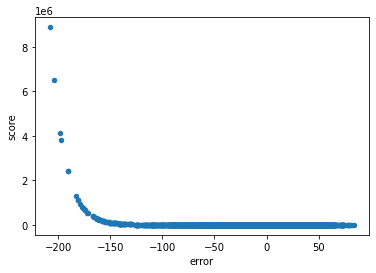

In [255]:
RUL.plot(kind='scatter', x='error', y='score')

In [257]:
RUL['score'].max(), RUL['score'].min()

(8886109, 0)

<AxesSubplot:xlabel='error', ylabel='score'>

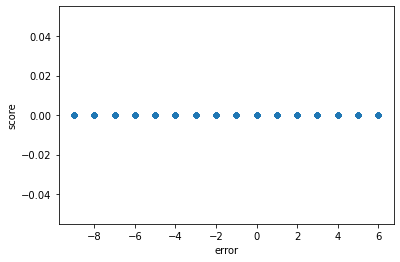

In [267]:
RUL[RUL['score'] == RUL['score'].min()].plot(kind='scatter', x='error', y='score')